This is a notebook to play around with TensorFlow and convolutional neural networks.

We're using a convnet with the following structure (like VGGNet but smaller):

    input    28x28x1
    conv1_1  32 kernels
    conv1_2  32 kernels
    pool1    14x14x32
    conv2_1  64 kernels
    conv2_2  64 kernels
    pool2    7x7x64
    fc3      7x7x64x128   with dropout
    fc4      128          with dropout
    fc5      10           softmax
    
All convolutions are 3x3. All pooling is 2x2.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (16.0, 8.0)   # change default figure size

/opt/conda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loading the data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels.

The pixels are values between 0 and 255. We convert those to floats in the range 0.0 - 1.0.

The training data has 42000 rows. Each row in the training data CSV begins with the label, followed by the 784 pixel values.

The test set has 28000 rows, but we don't have the labels. For evaluating the network we'll make our own test set instead.

In [2]:
from glob import glob
import cv2
from random import shuffle

path_data = []
k = 0
for i in glob('marcado/*.jpg'):
    path_data.append(i)
    k += 1
kk = 0
for i in glob('no_marcado/*.jpg'):
    path_data.append(i)
    kk += 1
    if kk>k:
        #break
        pass
    
shuffle(path_data)
data_X = []
data_y = []
for i in path_data:
    data_X.append(cv2.resize(cv2.cvtColor(cv2.imread(i),cv2.COLOR_RGB2GRAY),(28,28)))
    if('no' in i):
        data_y.append(1)
    else:
        data_y.append(0)
    
image_width = 28
image_height = 28
num_pixels = image_width * image_height

num_examples = len(data_X)
num_examples

2132

In [3]:
def onehot(labels, num_outputs):
    m = len(labels)
    y = np.zeros((m, num_outputs))
    for i, label in enumerate(labels):
        y[i][int(label)] = 1.0
    return y

Show the pixel data for a few images:

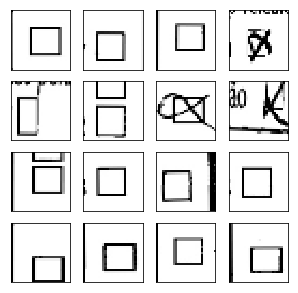

In [4]:
fig = plt.figure(figsize=(5, 5))
num_horz = 4
num_vert = 4
for i in range(num_horz * num_vert):
    ax = fig.add_subplot(num_vert, num_horz, i + 1, xticks=[], yticks=[])
    image_data = data_X[i]#(data_X[i] * 255).reshape(image_width, image_height)
    ax.imshow(image_data, cmap=cm.Greys_r, interpolation='none')

Randomly split the data into train, validate, and test sets. Ideally, each class is represented in equal amounts in the three sets.

For speed reasons, we're not doing cross validation but will only use a single set of validation examples.

In [5]:
np.random.seed(666)
#indices = np.random.permutation(len(data_X))

num_train = int(0.6 * num_examples)
num_val = int(0.2 * num_examples)
num_test = num_examples - num_val - num_train

X_train = []
X_train_ = data_X[:num_train]
for elem in range(len(X_train_)):
    X_train.append(X_train_[elem].flatten())
y_train = data_y[:num_train]

X_val = []
X_val_   = data_X[num_train:-num_test]
for elem in range(len(X_val_)):
    X_val.append(X_val_[elem].flatten())
y_val   = data_y[num_train:-num_test]

X_test = []
X_test_  = data_X[-num_test:]
for elem in range(len(X_test_)):
    X_test.append(X_test_[elem].flatten())
y_test  = data_y[-num_test:]

X_mean = np.zeros((1, num_pixels))
X_std = np.zeros((1, num_pixels))

y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test

y_train = onehot(y_train, 2)
y_val   = onehot(y_val, 2)
y_test  = onehot(y_test, 2)

In [6]:
%xdel data_X
%xdel data_y

Normalize the input data. Calculate the mean and standard deviation of each feature on the training data, not on validation or test examples.

In [7]:
X_mean = np.mean(X_train, axis=0, keepdims=True)
X_std = np.std(X_train, axis=0, keepdims=True)

X_train -= X_mean
X_val   -= X_mean
X_test  -= X_mean

Plot the mean image:

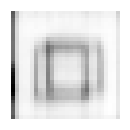

In [8]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_frame_on(False)
ax.set_axis_off()
image_data = (X_mean * 255).reshape(image_width, image_height)
ax.imshow(image_data, cmap=cm.Greys_r, interpolation='none')

Plot the std image:

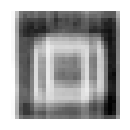

In [9]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_frame_on(False)
ax.set_axis_off()
image_data = (X_std * 255).reshape(image_width, image_height)
ax.imshow(image_data, cmap=cm.Greys_r, interpolation='none')

## Network architecture

Create the model, a convolutional neural network.

In [10]:
tf.set_random_seed(7777)
tf.reset_default_graph()

# The input data.
x = tf.placeholder(tf.float32, [None, 784], name="x-input")
y = tf.placeholder(tf.float32, [None,2], name="y-input")

learning_rate = tf.placeholder(tf.float32, name="learning-rate")
reg_lambda = tf.placeholder(tf.float32, name="regularization")
keep_prob = tf.placeholder(tf.float32, name="dropout-probability")

# Input Layer
# Reshape X to 4-D tensor: [batch_size, width, height, channels]
# MNIST images are 28x28 pixels, and have one color channel
input_layer = tf.reshape(x, [-1, 28, 28, 1])

# Convolutional Layer #1
# Computes 32 features using a 5x5 filter with ReLU activation.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 28, 28, 1]
# Output Tensor Shape: [batch_size, 28, 28, 32]
conv1 = tf.layers.conv2d(
  inputs=input_layer,
  filters=32,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)

# Pooling Layer #1
# First max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 28, 28, 32]
# Output Tensor Shape: [batch_size, 14, 14, 32]
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 14, 14, 32]
# Output Tensor Shape: [batch_size, 14, 14, 64]
conv2 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)

# Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 14, 14, 64]
# Output Tensor Shape: [batch_size, 7, 7, 64]
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 7, 7, 64]
# Output Tensor Shape: [batch_size, 7 * 7 * 64]
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

# Dense Layer
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 7 * 7 * 64]
# Output Tensor Shape: [batch_size, 1024]
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

# Add dropout operation; 0.6 probability that element will be kept
dropout = tf.layers.dropout(
  inputs=dense, rate=0.4)

# Logits layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, 10]
logits = tf.layers.dense(inputs=dropout, units=2)

loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logits)
#loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(logits), reduction_indices=[1]))

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())

correct_prediction = tf.equal(logits,y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope("inference"):
    inference = tf.argmax(logits, 1)

In [ ]:
'''import math

tf.set_random_seed(7777)
tf.reset_default_graph()

# Init the weights with a small amount of noise.
def weight_variable(name, shape):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())    

# Use a slightly positive initial bias to avoid dead ReLUs.
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution with stride 1 and enough zero padding to keep width/height the same.
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Plain old max pooling over 2x2 blocks.
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# The input data.
x = tf.placeholder(tf.float32, [None, 784], name="x-input")
y = tf.placeholder(tf.float32, [None], name="y-input")

with tf.name_scope("hyperparameters"):
    learning_rate = tf.placeholder(tf.float32, name="learning-rate")
    reg_lambda = tf.placeholder(tf.float32, name="regularization")

# Reshape x into a 4d tensor. -1 is because we don't know the number of examples
# yet. 28x28 is the width and height, 1 is the number of color channels.
x_image = tf.reshape(x, [-1, 28, 28, 1])

with tf.name_scope("conv1_1"):
    W_conv1_1 = weight_variable("W_conv1_1", [5, 5, 1, 32])
    b_conv1_1 = bias_variable([32])
    h_conv1_1 = tf.nn.relu(conv2d(x_image, W_conv1_1) + b_conv1_1)

with tf.name_scope("conv1_2"):
    W_conv1_2 = weight_variable("W_conv1_2", [5, 5, 32, 32])
    b_conv1_2 = bias_variable([32])
    h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, W_conv1_2) + b_conv1_2)

with tf.name_scope("pool1"):
    h_pool1 = max_pool_2x2(h_conv1_2)

with tf.name_scope("conv2_1"):
    W_conv2_1 = weight_variable("W_conv2_1", [5, 5, 32, 64])
    b_conv2_1 = bias_variable([64])
    h_conv2_1 = tf.nn.relu(conv2d(h_pool1, W_conv2_1) + b_conv2_1)

with tf.name_scope("conv2_2"):
    W_conv2_2 = weight_variable("W_conv2_2", [5, 5, 64, 64])
    b_conv2_2 = bias_variable([64])
    h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, W_conv2_2) + b_conv2_2)

with tf.name_scope("pool2"):
    h_pool2 = max_pool_2x2(h_conv2_2)

    # Reshape the output into a vector that we can pass to the FC layer.
    h_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])

with tf.name_scope("fc3"):
    W_fc3 = weight_variable("W_fc3", [7 * 7 * 64, 128])
    b_fc3 = bias_variable([128])
    h_fc3 = tf.nn.relu(tf.matmul(h_flat, W_fc3) + b_fc3)

with tf.name_scope("fc3-dropout"):
    # Apply dropout to reduce overfitting.
    keep_prob = tf.placeholder(tf.float32, name="dropout-probability")
    h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

with tf.name_scope("fc4"):
    W_fc4 = weight_variable("W_fc4", [128, 128])
    b_fc4 = bias_variable([128])
    h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

with tf.name_scope("fc4-dropout"):
    h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

with tf.name_scope("fc5"):
    W_fc5 = weight_variable("W_fc5", [128, 1])
    b_fc5 = bias_variable([1])
    y_pred = tf.nn.softmax(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)

# Softmax, so use cross entropy loss.
with tf.name_scope("loss-function"):
    loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))
    
    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(b_fc3) +
                    tf.nn.l2_loss(W_fc4) + tf.nn.l2_loss(b_fc4) +
                    tf.nn.l2_loss(W_fc5) + tf.nn.l2_loss(b_fc5))
    loss += 5e-4 * regularizers

# Use ADAM (instead of plain gradient descent).
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

# The accuracy op computes the % correct on a dataset with labels. 
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred,y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# For doing inference on the test set without labels.
with tf.name_scope("inference"):
    inference = tf.argmax(y_pred, 1)
'''

In [11]:
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()

## Training

We train in mini batches. The `next_batch()` function returns the next mini batch of training data. If we reach the end of the training set, it counts as an epoch. We then shuffle the data and start over.

In [12]:
index_in_epoch = 0
epochs_completed = 0

# Based on code from learn/datasets/mnist.py
def next_batch(batch_size):
    global index_in_epoch, epochs_completed, X_train, y_train, y_train_labels
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # Epoch completed?
    if index_in_epoch > len(X_train):
        # Shuffle the data.
        perm = np.arange(len(X_train))
        np.random.shuffle(perm)
        #X_train = X_train[perm]
        #y_train = y_train[perm]
        #y_train_labels = y_train_labels[perm]

        # Start next epoch.
        start = 0
        index_in_epoch = batch_size
        epochs_completed += 1

    end = index_in_epoch
    return X_train[start:end], y_train[start:end]

Helper function that is used by grid search and random search. 

In [13]:
import math
import time

def train_and_validate(max_steps, batch_size, print_every, verbose=True, acceptable_loss=0.001, smooth_loss=False):
    sess.run(init)

    loss_history = []
    loss_avg = 0
    smooth_steps = 20

    # Used by next_batch()
    global index_in_epoch, epochs_completed
    index_in_epoch = 0
    epochs_completed = 0

    for step in range(max_steps):
        start_time = time.time()

        # Get the next mini-batch of training data.
        batch_xs, batch_ys = next_batch(100)
        #batch_xs = []
        #for elem in range(len(batch_xs_)):
        #    batch_xs.append(batch_xs_[elem].flatten())
        feed_dict = { x: batch_xs, y: batch_ys, learning_rate: lr, reg_lambda: reg, keep_prob: 0.5 }

        # Run the network.
        _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)

        duration = time.time() - start_time

        # If enabled, we calculate the average loss over the last X steps, since
        # the loss can be a bit jittery when using stochastic gradient descent.
        if smooth_loss:
            loss_avg += loss_value
            if step % smooth_steps == 0:
                if step > 0: loss_avg /= smooth_steps
                loss_history.append(loss_avg)
                loss_avg = 0
        else:
            loss_history.append(loss_value)
        
        # Print the loss once every so many steps.
        if (step % print_every == 0) and verbose:
            print("    step: %4d, epoch: %2d, loss: %.3f (%.3f sec)" % \
                      (step, epochs_completed, loss_value, duration))

        # Stop the gradient descent if a user-specified loss is reached.
        if loss_value <= acceptable_loss or math.isnan(loss_value):
            print("    Loss is below acceptable limit, ending training after %d steps" % step)
            break

    if verbose:
        print("Final loss: %f" % loss_value)

    # Calculate cross validation score.
    score = sess.run(accuracy, feed_dict={x: X_val, y: y_val, keep_prob: 1.0})
    if verbose:
        print("Validation score: %g" % score)

    return loss_history, loss_value, score

To do a grid search to find the best learning rate and regularization, run the next cell.

In [14]:
# Hyperparameters used in the grid search
learning_rates = [0.001, 0.003, 0.01]
reg_lambdas = [0, 0.1, 0.3]            # regularization strength

from itertools import product
grid = list(product(learning_rates, reg_lambdas))

verbose = True

To do a random search, run the next cell. 

This gives better results than grid search. Because we're doing many random searches, you want to limit the number of epochs or it takes forever. First you run a coarse search, then you run a finer search.

In [15]:
# How many random searches to perform
max_search = 10

grid = []
for i in range(max_search):
    lr = 10**np.random.uniform(-5, -2)
    reg = 10**np.random.uniform(-3, 1)
    grid.append((lr, reg))
    
verbose = False

To do final training before you do inference, run the next cell. This uses the learning rate and regularization that you found with grid search or random search.

In [16]:
grid = [(0.0003, 0.0)]
verbose = True

Train the model.

In [17]:
print("Training %d examples" % X_train.shape[0])

scores = []
start_time = time.time()
loss_history = {}

for i, params in enumerate(grid):
    lr, reg = params
    
    if verbose:
        print("*** learning rate: %g, regularization: %g" % (lr, reg))
    
    hist, loss_value, score = train_and_validate(max_steps=200, batch_size=20, print_every=5,\
                                                 verbose=verbose, acceptable_loss=0.00001, smooth_loss=False)

    if not verbose:
        print("score: %0.6f, loss: %0.6f, rate: %0.6f, reg: %0.6f (%d/%d)" % (score, loss_value, lr, reg, i+1, max_search))

    key = "learn: %g, reg: %g" % (lr, reg)
    loss_history[key] = hist
    scores.append(score)

    if verbose:
        print()

print("Best validation score: %g" % np.max(scores))
print("Best parameters:", grid[np.argmax(scores)])
print("Time: %f sec" % (time.time() - start_time))

Training 1279 examples
*** learning rate: 0.0003, regularization: 0
    step:    0, epoch:  0, loss: 16.187 (0.705 sec)
    step:    5, epoch:  0, loss: 23.707 (0.649 sec)
    step:   10, epoch:  0, loss: 8.971 (0.645 sec)
    step:   15, epoch:  1, loss: 0.186 (0.647 sec)
    step:   20, epoch:  1, loss: 0.881 (0.643 sec)
    step:   25, epoch:  2, loss: 0.105 (0.648 sec)
    step:   30, epoch:  2, loss: 0.112 (0.718 sec)
    step:   35, epoch:  2, loss: 0.230 (0.656 sec)
    step:   40, epoch:  3, loss: 0.103 (0.644 sec)
    step:   45, epoch:  3, loss: 0.136 (0.646 sec)
    step:   50, epoch:  4, loss: 0.045 (0.949 sec)
    step:   55, epoch:  4, loss: 0.044 (0.666 sec)
    step:   60, epoch:  5, loss: 0.083 (0.648 sec)
    step:   65, epoch:  5, loss: 0.104 (0.661 sec)
    step:   70, epoch:  5, loss: 0.026 (0.652 sec)
    step:   75, epoch:  6, loss: 0.012 (0.674 sec)
    step:   80, epoch:  6, loss: 0.018 (0.653 sec)
    step:   85, epoch:  7, loss: 0.009 (0.649 sec)
    step:   

## Inference

Using the trained network to predict results.

In [18]:
start_time = time.time()

# Calculate accuracy on training data. This should be a good score, 
# but not *too* good or we're overfitting.

print('Train accuracy:',sess.run(accuracy, feed_dict={x: X_train, y: y_train, keep_prob: 1.0}))

duration = time.time() - start_time
print("duration %f sec" % duration)

# Calculate accuracy on validation data.
print('Validation accuracy:',sess.run(accuracy, feed_dict={x: X_val, y: y_val, keep_prob: 1.0}))

# Calculate accuracy on test data. We do have labels for these examples, 
# but the examples themselves were not used to train the network.
print('Test accuracy:',sess.run(accuracy, feed_dict={x: X_test, y: y_test, keep_prob: 1.0}))

Train accuracy: 0.0
duration 2.672502 sec
Validation accuracy: 0.0
Test accuracy: 0.0


## Confusion matrix

This shows how often any two classes are mixed up by the prediction. `C[i, j]` is the number of observations known to be in group `i` but predicted to be in group `j`.

[[  32.   17.]
 [   0.  378.]]


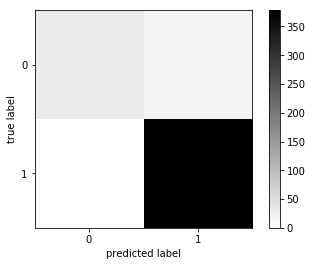

In [19]:
def confusion_matrix(target, predicted):
    assert(target.shape == predicted.shape)
    
    num_classes = len(np.unique(target))
    confusion = np.zeros((num_classes, num_classes))
    
    for i in range(len(target)):      
        confusion[target[i], predicted[i]] += 1
    
    return confusion

def plot_confusion_matrix(conf):
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.binary)
    plt.xticks(range(conf.shape[1]))
    plt.yticks(range(conf.shape[0]))
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.grid(False)
    plt.colorbar()
    
pred = sess.run(inference, feed_dict={x: X_test, keep_prob: 1.0})

conf = confusion_matrix(np.asarray(y_test_labels), pred)
print(conf)

plot_confusion_matrix(conf)

### Plot of the loss

By showing how the loss changes with every training epoch, we can see if the learning rate is any good.

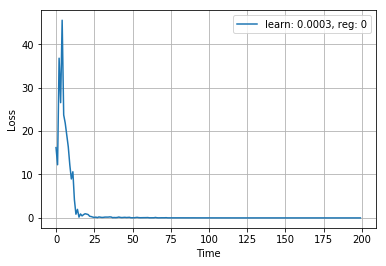

In [20]:
for k, v in loss_history.items():
    plt.plot(v, label=k)
plt.ylabel("Loss")
plt.xlabel("Time")
plt.legend()
plt.grid(True)